In [14]:
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob
import shutil
import sys
import torch
from PIL import Image
import ast
import albumentations as albu

In [15]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_path(row):
    row['image_path'] = f'./tensorflow-great-barrier-reef/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row
    
df = pd.read_csv("./tensorflow-great-barrier-reef/train-5folds.csv")

# Don't filter for annotated frames. Include frames with no bboxes as well!
df["num_bbox"] = df['annotations'].apply(lambda x: str.count(x, 'x'))
df_train = df

# Annotations 
df_train['annotations'] = df_train['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df_train['bboxes'] = df_train.annotations.progress_apply(get_bbox)

df_train = df_train.progress_apply(get_path, axis=1)

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

In [16]:
df_train.head()

,video_id,sequence,video_frame,sequence_frame,image_id,...,image_path,subsequence_id,fold,num_bbox,bboxes
0,0,40258,0,0,0-0,...,./tensorflow-great-barrier-reef/train_images/v...,1,2,0,[]
1,0,40258,1,1,0-1,...,./tensorflow-great-barrier-reef/train_images/v...,1,2,0,[]
2,0,40258,2,2,0-2,...,./tensorflow-great-barrier-reef/train_images/v...,1,2,0,[]
3,0,40258,3,3,0-3,...,./tensorflow-great-barrier-reef/train_images/v...,1,2,0,[]
4,0,40258,4,4,0-4,...,./tensorflow-great-barrier-reef/train_images/v...,1,2,0,[]


In [17]:
data = (df.num_bbox>0).value_counts()/len(df)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

No BBox: 79.07% | With BBox: 20.93%


# 🔨 Helper

In [18]:
# Modified from https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-infer
# Additions: 
#     confidence scores
def voc2yolo(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y1]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]/ image_height
    
    w = bboxes[..., 2] - bboxes[..., 0]
    h = bboxes[..., 3] - bboxes[..., 1]
    
    bboxes[..., 0] = bboxes[..., 0] + w/2
    bboxes[..., 1] = bboxes[..., 1] + h/2
    bboxes[..., 2] = w
    bboxes[..., 3] = h
    
    return bboxes

def yolo2voc(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

def coco2yolo(bboxes, image_height=720, image_width=1280):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def yolo2coco(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes

def voc2coco(bboxes, image_height=720, image_width=1280):
    bboxes  = voc2yolo(bboxes, image_height, image_width)
    bboxes  = yolo2coco(bboxes, image_height, image_width)
    return bboxes


def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)


def plot_one_box(x, img, score=None, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, "{}:{:.2f}".format(label, score), (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

def draw_bboxes(img, bboxes, scores, classes, class_ids, colors = None, show_classes = None, bbox_format = 'yolo', class_name = False, line_thickness = 2):  
     
    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors
    
    if bbox_format == 'yolo':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            try:
                score = scores[idx]
            except:
                score = None
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:
            
                x1 = round(float(bbox[0])*image.shape[1])
                y1 = round(float(bbox[1])*image.shape[0])
                w  = round(float(bbox[2])*image.shape[1]/2) #w/2 
                h  = round(float(bbox[3])*image.shape[0]/2)

                voc_bbox = (x1-w, y1-h, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             score= score if score else None,
                             color = color,
                             label = cls if class_name else str(get_label(cls)),
                             line_thickness = line_thickness)
            
    elif bbox_format == 'coco':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            try:
                score = scores[idx]
            except:
                score = None
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:            
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                w  = int(round(bbox[2]))
                h  = int(round(bbox[3]))

                voc_bbox = (x1, y1, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             score = score if score else None,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)
                
    elif bbox_format == 'voc_pascal':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            try:
                score = scores[idx]
            except:
                score = None
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes: 
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                x2 = int(round(bbox[2]))
                y2 = int(round(bbox[3]))
                voc_bbox = (x1, y1, x2, y2)
                plot_one_box(voc_bbox, 
                             image,
                             score = score if score else None,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)
    else:
        raise ValueError('wrong bbox format')

    return image

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

In [19]:
def predict(model, img, size=768, augment=False):
    height, width = img.shape[:2]
    results = model(img, size=size, augment=augment)  # custom inference size
    preds   = results.pandas().xyxy[0]
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values
    if len(bboxes):
        bboxes  = voc2coco(bboxes,height,width).astype(int)
        confs   = preds.confidence.values
        return bboxes, confs
    else:
        return [],[]
    
def format_prediction(bboxes, confs):
    annot = ''
    if len(bboxes)>0:
        for idx in range(len(bboxes)):
            xmin, ymin, w, h = bboxes[idx]
            conf             = confs[idx]
            annot += f'{conf} {xmin} {ymin} {w} {h}'
            annot +=' '
        annot = annot.strip(' ')
    return annot

def show_img(img, bboxes, confis, bbox_format='yolo', colors=colors):
    names  = ['starfish']*len(bboxes)
    labels = [0]*len(bboxes)
    img    = draw_bboxes(img = img,
                           bboxes = bboxes,
                           scores = confis,
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = bbox_format,
                           line_thickness = 2)
    return Image.fromarray(img)

In [20]:
def IOU_coco(bbox1, bbox2):
    '''
        adapted from https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
    '''
    x_left = max(bbox1[0], bbox2[0])
    y_top = max(bbox1[1], bbox2[1])
    x_right = min(bbox1[0] + bbox1[2], bbox2[0] + bbox2[2])
    y_bottom = min(bbox1[1] + bbox1[3], bbox2[1] + bbox2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = bbox1[2] * bbox1[3]
    bb2_area = bbox2[2] * bbox2[3]
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [21]:
def load_model(ckpt_path, conf=0.01, iou=0.50):
    model = torch.hub.load('./yolov5',
                           'custom',
                           path=ckpt_path,
                           source='local',
                           force_reload=True)  # local repo
    model.conf = conf  # NMS confidence threshold
    model.iou  = iou  # NMS IoU threshold
    model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 1000  # maximum number of detections per image
    return model

In [22]:
def load_model_tph(ckpt_path, conf=0.25, iou=0.50):
    model = torch.hub.load('./tph-yolov5',
                           'custom',
                           path=ckpt_path,
                           source='local',
                           force_reload=True)  # local repo
    model.conf = conf  # NMS confidence threshold
    model.iou  = iou  # NMS IoU threshold
    model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 1000  # maximum number of detections per image
    return model

In [23]:
# Modified from https://www.kaggle.com/remekkinas/yolox-inference-on-kaggle-for-cots-lb-0-507
# Additions: 
#     auto converts to xywh format
#     converts tensors to list of floats
# Updates:
# i changed it to yolov5 version. code is still dirty
def yolov5_inference(img, model, test_size, conf_threshold = 0.4):
    bboxes = []
    bbclasses = []
    scores = []
    
    preproc = ValTransform(legacy = False)
    
    tensor_img, _ = preproc(img, None, test_size)
    tensor_img = torch.from_numpy(tensor_img).unsqueeze(0)
    tensor_img = tensor_img.float()
    tensor_img = tensor_img.cuda()
    
    with torch.no_grad():
        outputs = model(tensor_img)
        outputs = postprocess(
                    outputs, num_classes, conf_threshold,
                    nmsthre, class_agnostic=True
                )
    
    if outputs[0] is None:
        return [], [], []
    
    outputs = outputs[0].cpu()
    bboxes = outputs[:, 0:4]
    
    bboxes /= min(test_size[0] / img.shape[0], test_size[1] / img.shape[1])
    bbclasses = outputs[:, 6]
    scores = outputs[:, 4] * outputs[:, 5]
    
    if len(bboxes) == 0:
        return [], [], []
    
    bboxes = bboxes.numpy()
    
    # format to coco
    bboxes[:, 2] = bboxes[:, 2] - bboxes[:, 0]
    bboxes[:, 3] = bboxes[:, 3] - bboxes[:, 1]    
    
    # Converts tensors to lists
    return bboxes, bbclasses.tolist(), scores.tolist()

In [24]:
# Modified from https://www.kaggle.com/remekkinas/yolox-inference-on-kaggle-for-cots-lb-0-507
# Additions: 
#     allows customized box color (BGR)
# Updates:
# i changed it to yolov5 version. code is still dirty
def draw_yolov5_predictions(img, bboxes, scores, bbclasses, classes_dict, boxcolor = (0,0,255)):
    outimg = img.copy()
    for i in range(len(bboxes)):
        box = bboxes[i]
        cls_id = int(bbclasses[i])
        score = scores[i]
        x0 = int(box[0])
        y0 = int(box[1])
        x1 = x0 + int(box[2])
        y1 = y0 + int(box[3])

        cv2.rectangle(outimg, (x0, y0), (x1, y1), boxcolor, 2)
        cv2.putText(outimg, '{}:{:.1f}%'.format(classes_dict[cls_id], score * 100), (x0, y0 - 3), cv2.FONT_HERSHEY_PLAIN, 0.8, boxcolor, thickness = 1)
    return outimg

# 🔭 Inference

## Helper

In [35]:
COCO_CLASSES = (
  "starfish",
)

# YOLOv5 Inference Size 
IMG_SIZE = 3600
AUGMENT  = True
CONF     = 0.01
IOU = 0.6

# Which IOU level to evaluate (Competition metric tests 0.3 to 0.8 with step of 0.05)
eval_IOU = 0.65

MODEL_PATH = './yolov5/runs/train/exp165/weights/v5m6best28.pt'
# MODEL_PATH = './tph-yolov5/runs/train/exp12/tph-v5m6best.pt'

In [37]:
# load model
model = load_model(MODEL_PATH, conf=CONF, iou=IOU)
# model = load_model_tph(MODEL_PATH, conf=CONF, iou=IOU)
# print(model)

YOLOv5  v6.0-164-gdae3d9d torch 1.9.0+cu102 CUDA:0 (NVIDIA GeForce RTX 2070, 8192MiB)

Fusing layers... 
Model Summary: 378 layers, 35248920 parameters, 0 gradients, 49.0 GFLOPs
Adding AutoShape... 


## Run Inference on **Not seen Data**

In [38]:
SELECTED_FOLD = 2
df_test = df_train[df_train.fold == SELECTED_FOLD]
# df_test = df_test[df_test['num_bbox'] > 0]
df_test

,video_id,sequence,video_frame,sequence_frame,image_id,...,image_path,subsequence_id,fold,num_bbox,bboxes
0,0,40258,0,0,0-0,...,./tensorflow-great-barrier-reef/train_images/v...,1,2,0,[]
1,0,40258,1,1,0-1,...,./tensorflow-great-barrier-reef/train_images/v...,1,2,0,[]
2,0,40258,2,2,0-2,...,./tensorflow-great-barrier-reef/train_images/v...,1,2,0,[]
3,0,40258,3,3,0-3,...,./tensorflow-great-barrier-reef/train_images/v...,1,2,0,[]
4,0,40258,4,4,0-4,...,./tensorflow-great-barrier-reef/train_images/v...,1,2,0,[]
...,...,...,...,...,...,...,...,...,...,...,...
21593,2,29859,8852,1080,2-8852,...,./tensorflow-great-barrier-reef/train_images/v...,133,2,0,[]
21594,2,29859,8853,1081,2-8853,...,./tensorflow-great-barrier-reef/train_images/v...,133,2,0,[]
21595,2,29859,8854,1082,2-8854,...,./tensorflow-great-barrier-reef/train_images/v...,133,2,0,[]
21596,2,29859,8855,1083,2-8855,...,./tensorflow-great-barrier-reef/train_images/v...,133,2,0,[]


### Get image paths and ground truth BB's

In [39]:
import copy

# deepcopy is required to avoid 

df_sample = df_test
image_paths = df_sample.image_path.tolist()
gt = copy.deepcopy(df_sample.bboxes.tolist())
gtmem = copy.deepcopy(df_sample.bboxes.tolist())

### Test your model is working

[]
[[664 256  34  29]
 [570 366  31  22]
 [916 484  27  29]
 [866 374  17  19]
 [785 405  29  22]
 [306   2  20  17]
 [  0  96  25  32]]


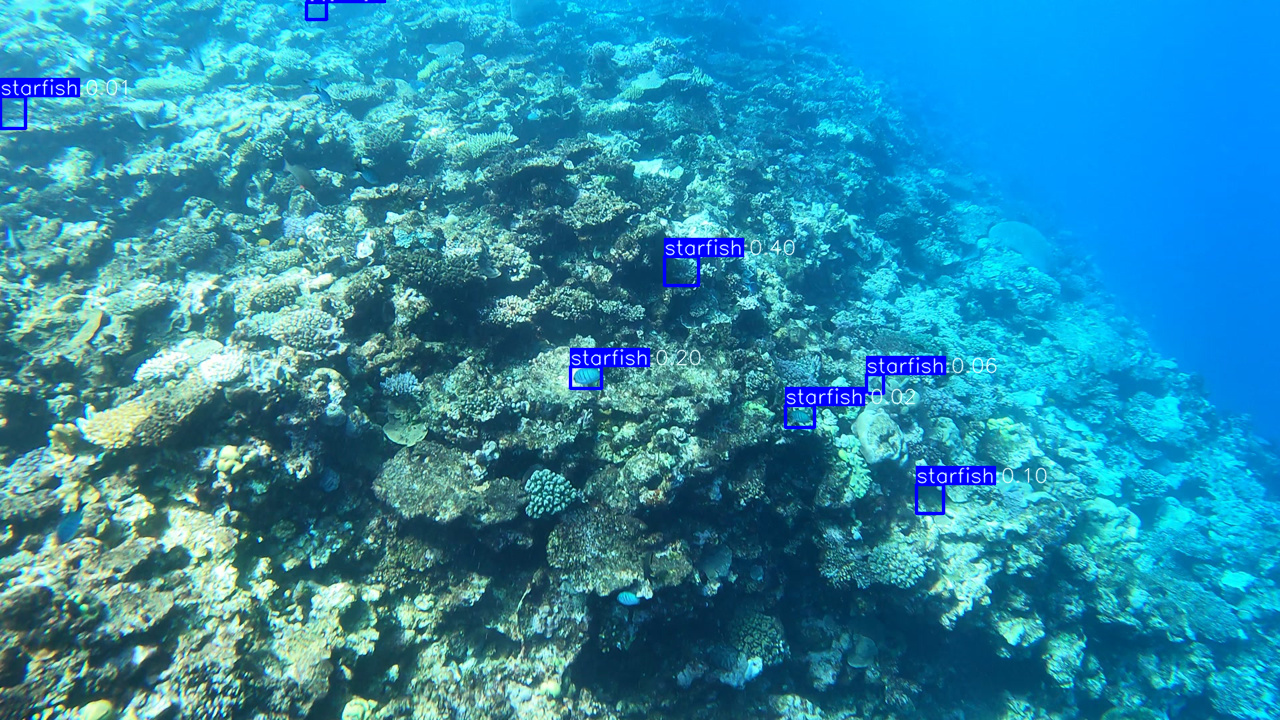

In [42]:
i = 1
TEST_IMAGE_PATH = image_paths[i]
img = cv2.imread(TEST_IMAGE_PATH)[...,::-1]

# img = TEST_IMAGE_PATH

# bboxes, bbclasses, scores, img = tempt_yolov5_inference(model, img)
bboxes, confis = predict(model, img, size=IMG_SIZE, augment=AUGMENT)
# bboxes = (bboxes * 1080/1920).astype(int)

# bboxes[:, :2] = (x - x1) * IMG_SIZE / (x2 - x1)
# y_new = (y - y1) * IMG_SIZE / (y2 - y1)


# bboxes = np.rint(bboxes)
print(gt[i])
print(bboxes)
# print(bboxes * (1080/1920))
# # Draw Green ground truth box
# out_image = draw_yolov5_predictions(img, gt[i], [1.0] * len(gt[i]), [0] * len(gt[i]), COCO_CLASSES, (0,255,0))
out_image = show_img(img, gt[i],[1.0]*len(gt[i]), bbox_format='coco', colors=[(0, 255, 0)]*(len(bboxes)))

# # Draw Red inference box
out_image = show_img(np.array(out_image), bboxes,confis, bbox_format='coco', colors=[(0,0,255)]*(len(bboxes)))

display(out_image)

# Assess Model Performance

In [44]:
bboxes_all = []
scores_all = []

sharp_filter = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
def gamma_enhance(img, gamma=1.0):
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    return cv2.LUT(img, lookUpTable)

for i in tqdm(range(len(image_paths))):
    img = cv2.imread(image_paths[i])[...,::-1]
    img = cv2.filter2D(gamma_enhance(img, gamma=2), -1, sharp_filter)
    bboxes, scores = predict(model, img, size=IMG_SIZE, augment=AUGMENT)
    bboxes_all.append(bboxes)
    scores_all.append(scores)

  0%|          | 0/2599 [00:00<?, ?it/s]

In [ ]:
# bboxes_all = np.array(bboxes_all)
# scores_all = np.array(scores_all)

In [45]:
F2list = []
F2max = 0.0
F2maxat = -1.0

for c in tqdm(np.arange(0.0, 1.0, 0.01)):
    F2_per_conf = []
    for eval_IOU in np.linspace(0.3, 0.8, 11):
        gt = copy.deepcopy(df_sample.bboxes.tolist())
        # Confidence scores of true positives, false positives and count false negatives
        TP = [] # Confidence scores of true positives
        FP = [] # Confidence scores of true positives
        FN = 0  # Count of false negative boxes
    
#         for i in tqdm(range(len(image_paths))):

#             TEST_IMAGE_PATH = image_paths[i]
#             img = cv2.imread(TEST_IMAGE_PATH)
#             img = cv2.imread(TEST_IMAGE_PATH)[...,::-1]
#             bboxes, scores = predict(model, img, size=IMG_SIZE, augment=AUGMENT)

        for i, (bboxes, scores) in enumerate(zip(bboxes_all, scores_all)):
            # Test YOLOV5
            gt0 = gt[i]
            if len(bboxes) == 0:
                # all gt are false negative
                FN += len(gt0)
            else:
                bb = bboxes.copy().tolist()
                for idx, b in enumerate(bb):
                    b.append(scores[idx])
                bb.sort(key = lambda x: x[4], reverse = True)

                if len(gt0) == 0:
                    # all bboxes are false positives
                    for b in bb:
                        FP.append(b[4])
                else:
                    # match bbox with gt
                    for b in bb:
                        matched = False
                        for g in gt0:
                            # check whether gt box is already matched to an inference bb
                            if len(g) == 4:
                                # g bbox is unmatched
                                if IOU_coco(b, g) >= eval_IOU:
                                    g.append(b[4]) # assign confidence values to g; marks g as matched
                                    matched = True
                                    TP.append(b[4])
                                    break
                        if not matched:
                            FP.append(b[4])
                    for g in gt0:
                        if len(g) == 4:
                            FN += 1
                    
        FNcount = FN + sum(1 for i in TP if i < c)
        TPcount = sum(1 for i in TP if i >= c)
        FPcount = sum(1 for i in FP if i >= c)
        R = TPcount / (TPcount + FNcount + 0.0001)
        P = TPcount / (TPcount + FPcount + 0.0001)
        F2 = (5 * P * R) / (4 * P + R + 0.0001)
        F2_per_conf.append(F2)
    
    avg_F2 = np.mean(F2_per_conf)
    F2list.append((c, avg_F2))
        
    if F2max < avg_F2:
        F2max = avg_F2
        F2maxat = c

plt.scatter(*zip(*F2list))
plt.title("CONF vs Average F2 score")
plt.xlabel('CONF')
plt.ylabel('Average F2')
plt.show()

print(f'F2 max is {F2max} at CONF = {F2maxat}')

  0%|          | 0/100 [00:00<?, ?it/s]

F2 max is 0.6775930579043024 at CONF = 0.56


C:\Users\rajag\AppData\Local\Temp/ipykernel_23008/2492309448.py:75: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
